In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import multiprocessing
import time
import numpy as np
import scipy as sp
import emcee
import sys
import pickle
import TPmod
from scipy import interpolate 
from IPython.display import display
%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
BTprof = np.loadtxt("BTtemp800_45_13.dat")

In [3]:
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
#logcoarsePress = np.arange(-4.0, 3.0, 0.5)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.1)
finePress = pow(10,logfinePress)
# forward model wants pressure in mbar
press = finePress
nprof = coarsePress.size
proftype = 2

In [4]:
tfit = sp.interpolate.splrep(np.log10(coarsePress),BTprof,s=0)
BTfine = np.asfortranarray(sp.interpolate.splev(np.log10(press),tfit,der=0),dtype='d')
err_BT = np.ones_like(BTfine)
err_BT[:] = 10.00

In [5]:
def lnlike(theta, press, temp, terr):
    madTP = TPmod.set_prof(proftype,coarsePress,press,theta)
    s2=terr**2
    lnlik = -0.5*np.sum((((BTfine - madTP)**2) / s2) + np.log(2.*np.pi*s2))
    return lnlik
                        

In [6]:
def lnprior(theta,press):
    a1 = theta[0]
    a2 = theta[1]
    P1 = theta[2]
#    P2 = theta[3]
    P3 = theta[3]
    T3 = theta[4]
    if 0. < a1 < 1. and 0. < a2 < 1.0 and T3 > 0.0 and P3 > P1 and P1 > press[0] and P3 < press[press.size-1]:
        return 0.0
    return -np.inf

In [7]:
def lnprob(theta, press, temp, terr):
    lp = lnprior(theta,press)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, press, temp, terr)

In [8]:
ndim, nwalkers = 5, 240
p0 = np.empty([nwalkers,ndim])

In [9]:
p0[:,0] = np.random.rand(nwalkers).reshape(nwalkers)
p0[:,1] = np.random.rand(nwalkers).reshape(nwalkers)
p0[:,2] = 1e-4 + (np.random.rand(nwalkers).reshape(nwalkers) * 10.)
#p0[:,3] = p0[:,2] + np.random.rand(nwalkers).reshape(nwalkers) * 50.
p0[:,3] = p0[:,3] + np.random.rand(nwalkers).reshape(nwalkers) * 100.
p0[:,4] = np.random.rand(nwalkers).reshape(nwalkers) * 3000.0

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(press, BTfine, err_BT),threads=4)

In [11]:
start_time = time.time()
sampler.run_mcmc(p0, 20000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 620.831709146 seconds ---


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [12]:
samples = sampler.chain[:, 18000:, :].reshape((-1, ndim))
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))
print sampler.chain.shape

Mean acceptance fraction: 0.049
(240, 20000, 5)


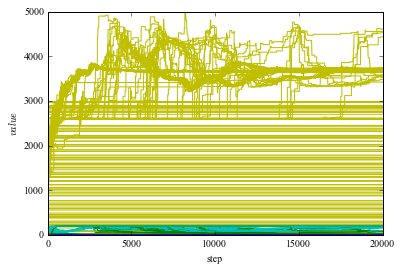

In [13]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0, 20000, 0.,5000.])
index = np.arange(20000)
for i in range(0,240):
    plt.plot(index[:],sampler.chain[i,:,0],'r-')
    plt.plot(index[:],sampler.chain[i,:,1],'b-')
    plt.plot(index[:],sampler.chain[i,:,2],'g-')
    plt.plot(index[:],sampler.chain[i,:,3],'c-')
    plt.plot(index[:],sampler.chain[i,:,4],'y-')
#    plt.plot(index[:],sampler.chain[i,:,5],'y-')
    
plt.ylabel(r'$value$')
plt.xlabel('step')


In [14]:
 a1 , a2, P1,P3, T3 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [15]:
print a1
print a2
print P1
#print P2
print P3
print T3

(0.4914625510382109, 0.13117454233371273, 0.20070090556267894)
(0.190881303531512, 0.53043107356379871, 0.096671446077687226)
(3.3930197039755821, 70.241504183789388, 2.2603202000097586)
(199.51345076466001, 5.3415890618457693e+228, 0.30644344215451724)
(2599.889809659644, 1070.2015589792145, 1569.8088967612518)


In [16]:
test= [a1[0],a2[0],P1[0], P3[0],T3[0]]
madprof =  TPmod.set_prof(proftype,coarsePress,press,test)
print test

[0.4914625510382109, 0.190881303531512, 3.3930197039755821, 199.51345076466001, 2599.889809659644]


TPmod.py:45: RuntimeWarning: invalid value encountered in log
  T0 = T3 - (np.log(P3/P1) / a2)**(1/beta)-(np.log(P1/P0) / a1)**(1/beta)


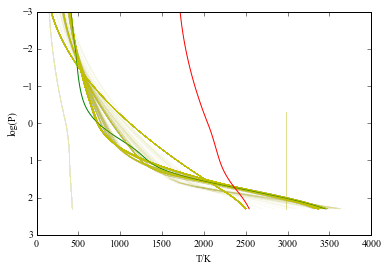

In [17]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([5., 4000.,3.0,-3.0])
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.fill_between(T[:,1],T[:,2], logP,facecolor='red',interpolate=True)
#plt.plot(T[:,1],logP,'r--')
#plt.plot(T[:,2],logP,'r--')
logP = np.log10(press)
plt.plot(BTfine,logP,'g-')
sampT = np.ones_like(test)
for sampT[:] in samples[(np.random.randint(len(samples[:,:]), size=5000)),:]:
    plotT = TPmod.set_prof(proftype,coarsePress,press,sampT)
    plt.plot(plotT,logP, color="y", alpha=0.02)

plt.plot(madprof,logP,'r-')

plt.ylabel(r'log(P)')
plt.xlabel('T/K')

#as

In [18]:
print madprof

[  763.12426201   933.16961781  1103.47838331  1274.09446012  1445.06174987
  1616.42415417  1703.52667115  1706.38027622  1709.67289746  1713.40453486
  1717.57518843  1722.18485817  1727.23354407  1732.72124613  1738.64796436
  1745.01369875  1751.81844931  1759.06221604  1766.74499893  1774.86679798
  1783.4276132   1792.42744459  1801.86629214  1811.74415586  1822.06103574
  1832.81693178  1844.011844    1855.64577237  1867.71871691  1880.23067762
  1893.18165449  1906.57164753  1920.40065673  1934.6686821   1949.37572363
  1964.52178133  1980.10685519  1996.13094522  2012.59405141  2029.49617377
  2046.83731229  2063.95691622  2080.00803644  2094.92783769  2108.96344625
  2122.36198837  2135.3705903   2148.23637832  2161.20647867  2174.52801762
  2188.44812142  2203.8744671   2221.90113003  2242.83807171  2266.68529215
  2293.44279134  2323.11056929  2355.68862599  2391.17624516  2426.9259264
  2460.14537167  2490.54355307  2517.82944274  2541.71201281]


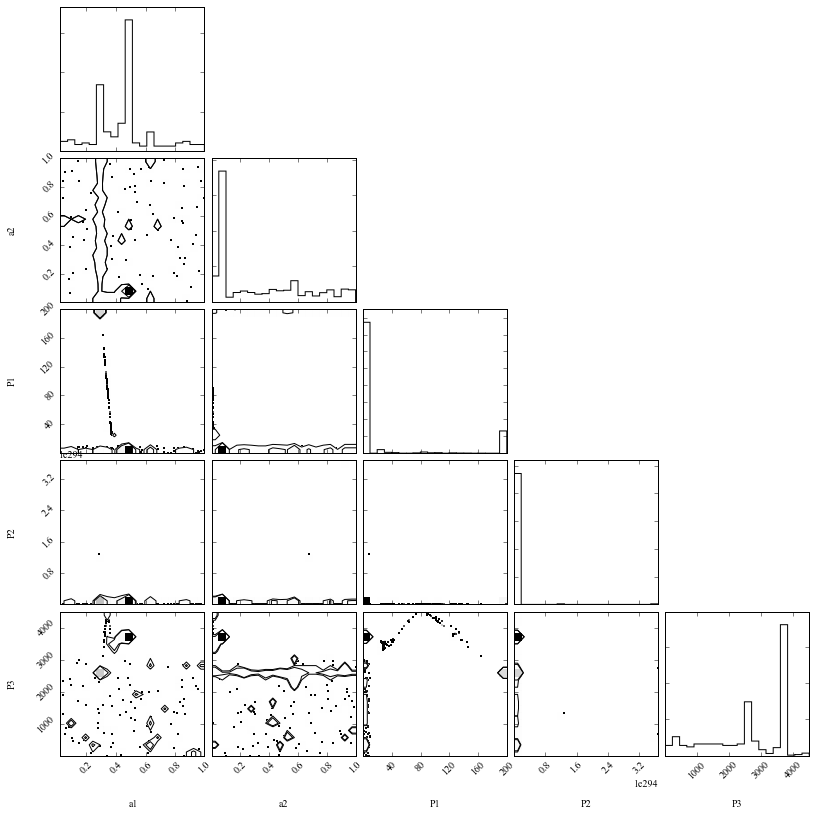

In [19]:
import corner
fig = corner.corner(samples, labels=["a1", "a2", "P1","P2","P3","T3"],range=[0.99,0.99,0.99,0.99,0.99])